# Hyper-paramter optimization experiments

> API details.

In [1]:
#hide
from nbdev.showdoc import *

In [2]:
# %load common.py
# export

import pandas
import os
import numpy
import seaborn
import logging
import matplotlib.pyplot as plt
from importlib import reload
from ehv import core

numpy.random.seed(42)

In [3]:
# export

from joblib import load, dump
import optuna

# Inspect hyper-param study

In [4]:
def load_studies(study_name, db_path, test_score_path):
    
    test_scores = load(test_score_path)
    
    data = []
    trial_data = []
    for i in range(3):
        for j in range(3):
            study = optuna.load_study(study_name % (i, j), storage=f"sqlite:////{db_path}")

            filtered_study = optuna.study.create_study(study_name=study.study_name)
            for trial in study.get_trials():
                if not ((trial.value is None) or (trial.value > 1)):
                    filtered_study.add_trial(trial)
                    
                    trial_data.append({
                        "outer": i, "repeat": j, "value": trial.value
                    })

            tmp = {
                "best_value": study.best_value, "test_score": test_scores[i][j],
                "outer": i, "repeat": j, "n_trials": len(filtered_study.trials), "study": filtered_study
            }

            tmp.update(study.best_params)

            data.append(tmp)
    
    return pandas.DataFrame(data), pandas.DataFrame(trial_data)

In [5]:
results1, trials1 = load_studies(
    "tmr_run1_%d_%d", "/home/maximl/Data/Experiment_data/weizmann/results/tmr_regression_run1_sgdmlp2.sqlite",
    "/home/maximl/Data/Experiment_data/weizmann/results/tmr_regression_run1_sgdmlp2.dat"
)

<ipython-input-4-98ab945d4e76>:14: ExperimentalWarning: add_trial is experimental (supported from v2.0.0). The interface can change in the future.
  filtered_study.add_trial(trial)


In [6]:
results2, trials2 = load_studies(
    "tmr_xgb_%d_%d", "/home/maximl/Data/Experiment_data/weizmann/results/tmr_regression_run1_xgb.sqlite",
    "/home/maximl/Data/Experiment_data/weizmann/results/tmr_regression_run1_xgb.dat"
)

<ipython-input-4-98ab945d4e76>:14: ExperimentalWarning: add_trial is experimental (supported from v2.0.0). The interface can change in the future.
  filtered_study.add_trial(trial)


## Performance

Text(0.5, 1.0, 'Best mean validation score')

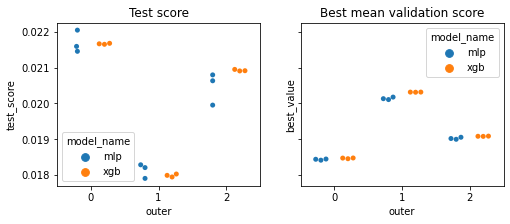

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(8,3), sharey=True)
seaborn.swarmplot("outer", "test_score", hue="model_name", data=pandas.concat([results1, results2]), ax=ax[0], dodge=True)
ax[0].set_title("Test score")
seaborn.swarmplot("outer", "best_value", hue="model_name", data=pandas.concat([results1, results2]), ax=ax[1], dodge=True)
ax[1].set_title("Best mean validation score")

## Studies

### XGB

We use the slice plot to inspect the convergence of a hyper-parameter study.

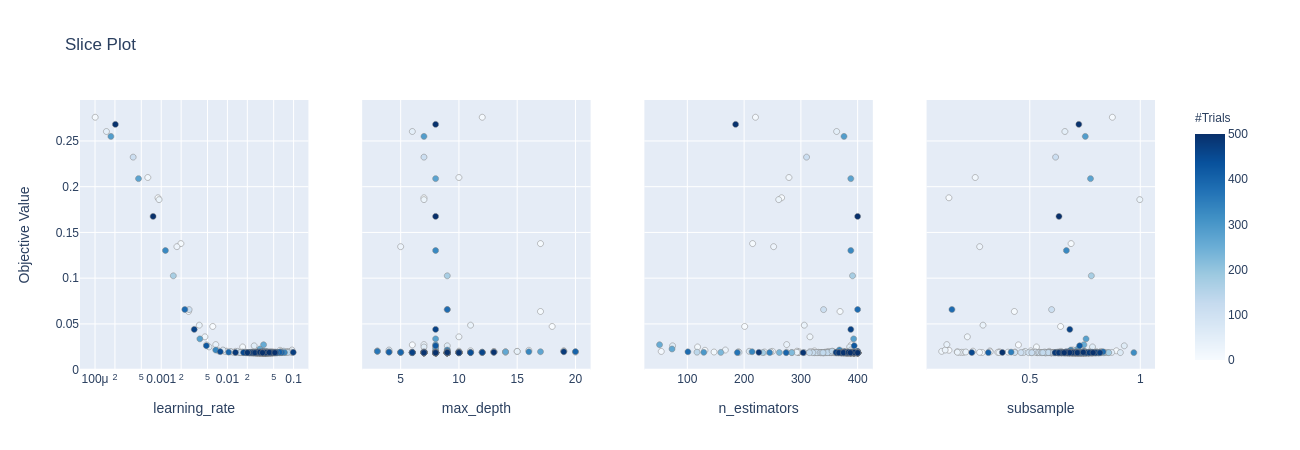

In [9]:
optuna.visualization.plot_slice(results2.loc[0, "study"], params=["learning_rate", "max_depth", "n_estimators", "subsample"])

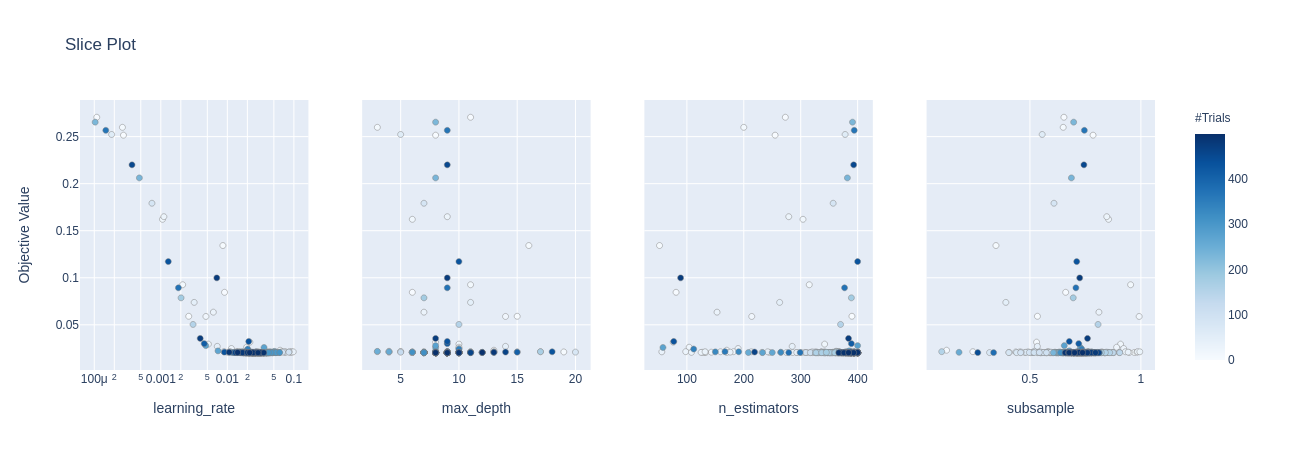

In [10]:
optuna.visualization.plot_slice(results2.loc[3, "study"], params=["learning_rate", "max_depth", "n_estimators", "subsample"])

We use the contour plot to inspect the cost landscape in a study. It also nicely shows convergence.

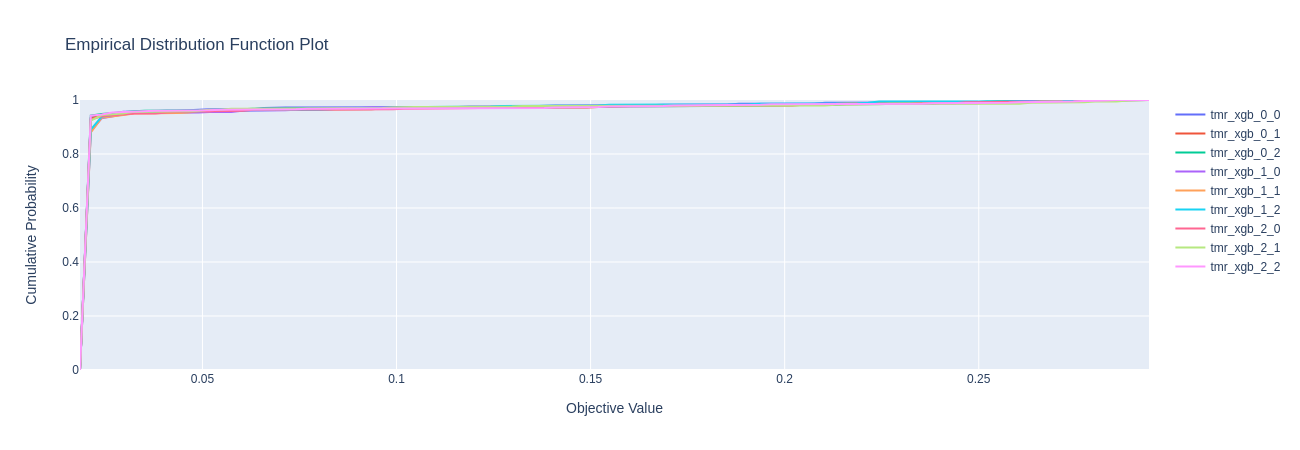

In [11]:
optuna.visualization.plot_edf(results2["study"])

### MLP

In [12]:
results1["avg_hidden_nodes_per_layer"] = results1.filter(regex="hidden_layer_size_.*").sum(axis=1) / results1["n_layers"]

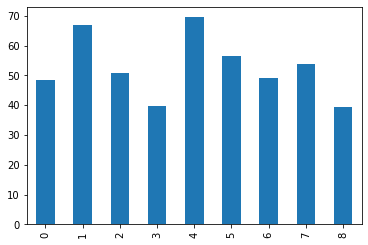

In [14]:
results1["avg_hidden_nodes_per_layer"].plot.bar()

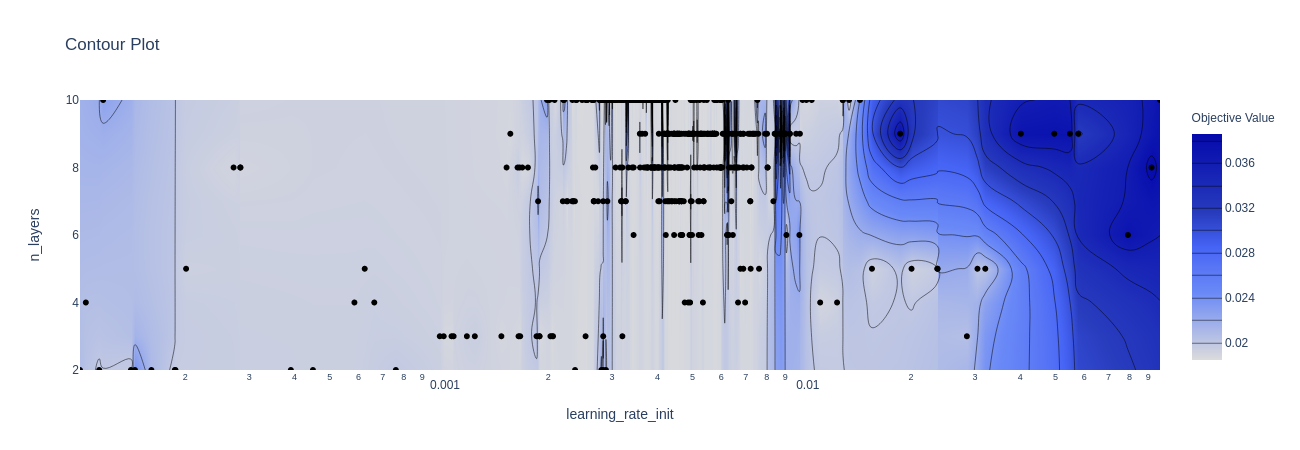

In [16]:
optuna.visualization.plot_contour(results1.loc[0, "study"], params=["learning_rate_init", "n_layers"])

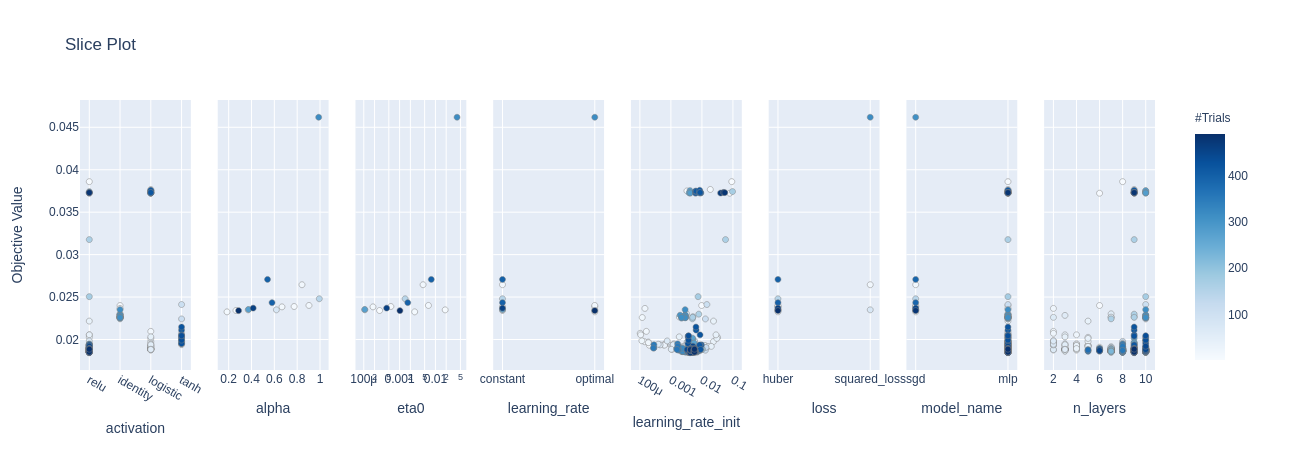

In [21]:
optuna.visualization.plot_slice(results1.loc[0, "study"], params=["eta0", "alpha", "learning_rate", "loss", "n_layers", "activation", "model_name", "learning_rate_init"])